# Simplified Plotting Routines for Quantum Circuits
Rick Muller

This program takes some of the circuit tricks that Brian Granger, Aaron Meurer and Ondrej Certik first developed in Sympy and [I subsequently updated](http://nbviewer.jupyter.org/gist/rpmuller/5843312).

I pulled out all of the code into a set of standalone python functions because I wanted to:
* have fewer dependencies for people to install;
* make a simpler code base to experiment with;
* separate the quantum circuit from the plotter from the simulator;
* experiment with scheduling quantum operations rather than plotting one gate in each time step.

There are lots of other tools you can do for circuit plotting.
* [Qasm2circ](https://www.media.mit.edu/quanta/qasm2circ/)
* [Q-circuit](http://physics.unm.edu/CQuIC/Qcircuit/)
* The aforementioned [Sympy circuit plotter](http://nbviewer.jupyter.org/gist/rpmuller/5843312)
and probably many more that I haven't used.

In [1]:
%matplotlib inline
import matplotlib
import numpy as np

In [12]:
def plot_quantum_circuit(gates,inits={},labels=[],plot_labels=True,**kwargs):
    """Use Matplotlib to plot a quantum circuit.
    gates     List of tuples for each gate in the quantum circuit.
              (name,target,control1,control2...). Targets and controls initially
              defined in terms of labels. 
    inits     Initialization list of gates, optional
    
    kwargs    Can override plot_parameters
    """
    plot_params = dict(scale = 1.0,fontsize = 14.0, linewidth = 1.0, 
                         control_radius = 0.05, not_radius = 0.15, 
                         swap_delta = 0.08, label_buffer = 0.0)
    plot_params.update(kwargs)
    scale = plot_params['scale']
    
    # Create labels from gates. This will become slow if there are a lot 
    #  of gates, in which case move to an ordered dictionary
    if not labels:
        labels = []
        for i,gate in enumerate_gates(gates):
            for label in gate[1:]:
                if label not in labels:
                    labels.append(label)
    
    nq = len(labels)
    ng = len(gates)
    wire_grid = np.arange(0.0, nq*scale, scale, dtype=float)
    gate_grid = np.arange(0.0, ng*scale, scale, dtype=float)
    
    fig,ax = setup_figure(nq,ng,gate_grid,wire_grid,plot_params)

    measured = measured_wires(gates,labels)
    draw_wires(ax,nq,gate_grid,wire_grid,plot_params,measured)
    
    if plot_labels: 
        draw_labels(ax,labels,inits,gate_grid,wire_grid,plot_params)

    draw_gates(ax,gates,labels,gate_grid,wire_grid,plot_params,measured)
    return ax

def enumerate_gates(l,schedule=False):
    "Enumerate the gates in a way that can take l as either a list of gates or a schedule"
    if schedule:
        for i,gates in enumerate(l):
            for gate in gates:
                yield i,gate
    else:
        for i,gate in enumerate(l):
            yield i,gate
    return

def measured_wires(l,labels,schedule=False):
    "measured[i] = j means wire i is measured at step j"
    measured = {}
    for i,gate in enumerate_gates(l,schedule=schedule):
        name,target = gate[:2]
        j = get_flipped_index(target,labels)
        if name.startswith('M'):
            measured[j] = i
    return measured

def draw_gates(ax,l,labels,gate_grid,wire_grid,plot_params,measured={},schedule=False):
    for i,gate in enumerate_gates(l,schedule=schedule):
        draw_target(ax,i,gate,labels,gate_grid,wire_grid,plot_params)
        if len(gate) > 2: # Controlled
            draw_controls(ax,i,gate,labels,gate_grid,wire_grid,plot_params,measured)
    return

def draw_controls(ax,i,gate,labels,gate_grid,wire_grid,plot_params,measured={}):
    linewidth = plot_params['linewidth']
    scale = plot_params['scale']
    control_radius = plot_params['control_radius']
    
    name,target = gate[:2]
    target_index = get_flipped_index(target,labels)
    controls = gate[2:]
    control_indices = get_flipped_indices(controls,labels)
    gate_indices = control_indices + [target_index]
    min_wire = min(gate_indices)
    max_wire = max(gate_indices)
    line(ax,gate_grid[i],gate_grid[i],wire_grid[min_wire],wire_grid[max_wire],plot_params)
    ismeasured = False
    for index in control_indices:
        if measured.get(index,1000) < i: 
            ismeasured = True
    if ismeasured:
        dy = 0.04 # TODO: put in plot_params
        line(ax,gate_grid[i]+dy,gate_grid[i]+dy,wire_grid[min_wire],wire_grid[max_wire],plot_params)
        
    for ci in control_indices:
        x = gate_grid[i]
        y = wire_grid[ci]
        if name in ['SWAP']:
            swapx(ax,x,y,plot_params)
        else:
            cdot(ax,x,y,plot_params)
    return

def draw_target(ax,i,gate,labels,gate_grid,wire_grid,plot_params):
    target_symbols = dict(CNOT='X',CPHASE='Z',NOP='',CX='X',CZ='Z')
    name,target = gate[:2]
    symbol = target_symbols.get(name,name) # override name with target_symbols
    x = gate_grid[i]
    target_index = get_flipped_index(target,labels)
    y = wire_grid[target_index]
    if not symbol: return
    if name in ['CNOT','TOFFOLI']:
        oplus(ax,x,y,plot_params)
    elif name in ['CPHASE']:
        cdot(ax,x,y,plot_params)
    elif name in ['SWAP']:
        swapx(ax,x,y,plot_params)
    else:
        text(ax,x,y,symbol,plot_params,box=True)
    return

def line(ax,x1,x2,y1,y2,plot_params):
    Line2D = matplotlib.lines.Line2D
    line = Line2D((x1,x2), (y1,y2),
        color='k',lw=plot_params['linewidth'])
    ax.add_line(line)

def text(ax,x,y,textstr,plot_params,box=False):
    linewidth = plot_params['linewidth']
    fontsize = plot_params['fontsize']
    if box:
        bbox = dict(ec='k',fc='w',fill=True,lw=linewidth)
    else:
        bbox= dict(fill=False,lw=0)
    ax.text(x,y,textstr,color='k',ha='center',va='center',bbox=bbox,size=fontsize)
    return

def oplus(ax,x,y,plot_params):
    Line2D = matplotlib.lines.Line2D
    Circle = matplotlib.patches.Circle
    not_radius = plot_params['not_radius']
    linewidth = plot_params['linewidth']
    c = Circle((x, y),not_radius,ec='k',
               fc='w',fill=False,lw=linewidth)
    ax.add_patch(c)
    line(ax,x,x,y-not_radius,y+not_radius,plot_params)
    return

def cdot(ax,x,y,plot_params):
    Circle = matplotlib.patches.Circle
    control_radius = plot_params['control_radius']
    scale = plot_params['scale']
    linewidth = plot_params['linewidth']
    c = Circle((x, y),control_radius*scale,
        ec='k',fc='k',fill=True,lw=linewidth)
    ax.add_patch(c)
    return

def swapx(ax,x,y,plot_params):
    d = plot_params['swap_delta']
    linewidth = plot_params['linewidth']
    line(ax,x-d,x+d,y-d,y+d,plot_params)
    line(ax,x-d,x+d,y+d,y-d,plot_params)
    return

def setup_figure(nq,ng,gate_grid,wire_grid,plot_params):
    scale = plot_params['scale']
    fig = matplotlib.pyplot.figure(
        figsize=(ng*scale, nq*scale),
        facecolor='w',
        edgecolor='w'
    )
    ax = fig.add_subplot(1, 1, 1,frameon=True)
    ax.set_axis_off()
    offset = 0.5*scale
    ax.set_xlim(gate_grid[0] - offset, gate_grid[-1] + offset)
    ax.set_ylim(wire_grid[0] - offset, wire_grid[-1] + offset)
    ax.set_aspect('equal')
    return fig,ax

def draw_wires(ax,nq,gate_grid,wire_grid,plot_params,measured={}):
    scale = plot_params['scale']
    linewidth = plot_params['linewidth']
    xdata = (gate_grid[0] - scale, gate_grid[-1] + scale)
    for i in range(nq):
        line(ax,gate_grid[0]-scale,gate_grid[-1]+scale,wire_grid[i],wire_grid[i],plot_params)
        
    # Add the doubling for measured wires:
    dy=0.04 # TODO: add to plot_params
    for i in measured:
        j = measured[i]
        line(ax,gate_grid[j],gate_grid[-1]+scale,wire_grid[i]+dy,wire_grid[i]+dy,plot_params)
    return

def draw_labels(ax,labels,inits,gate_grid,wire_grid,plot_params):
    scale = plot_params['scale']
    label_buffer = plot_params['label_buffer']
    fontsize = plot_params['fontsize']
    nq = len(labels)
    xdata = (gate_grid[0] - scale, gate_grid[-1] + scale)
    for i in range(nq):
        j = get_flipped_index(labels[i],labels)
        text(ax,xdata[0]-label_buffer,wire_grid[j],render_label(labels[i],inits),plot_params)
    return

def get_flipped_index(target,labels):
    """Get qubit labels from the rest of the line,and return indices

    >>> get_flipped_index('q0', ['q0', 'q1'])
    1
    >>> get_flipped_index('q1', ['q0', 'q1'])
    0
    """
    nq = len(labels)
    i = labels.index(target)
    return nq-i-1

def get_flipped_indices(targets,labels): return [get_flipped_index(t,labels) for t in targets]

def render_label(label, inits={}):
    """Slightly more flexible way to render labels.

    >>> render_label('q0')
    '$|q0\\\\rangle$'
    >>> render_label('q0', {'q0':'0'})
    '$|0\\\\rangle$'
    """
    if label in inits:
        s = inits[label]
        if s is None:
            return ''
        else:
            return r'$|%s\rangle$' % inits[label]
    return r'$|%s\rangle$' % label

# Define symbols to simplify writing
H,X,Y,Z,S,T,M = 'HXYZSTM'
CNOT,CPHASE,CZ,CX,TOFFOLI,SWAP,NOP = 'CNOT','CPHASE','CZ','CX','TOFFOLI','SWAP','NOP'
qa,qb,qc,qd,q0,q1,q2,q3 = 'q_a','q_b','q_c','q_d','q_0','q_1','q_2','q_3'

## Basic tests

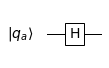

In [13]:
plot_quantum_circuit([(H,qa)])

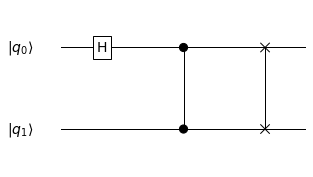

In [14]:
plot_quantum_circuit([(H,q0),(CPHASE,q1,q0),(SWAP,q1,q0)],labels=[q0,q1],scale=1.5)

# Examples from [qasm2circ page](http://www.media.mit.edu/quanta/qasm2circ)
## Example 1: EPR Creation

Goal:

<img src="http://www.media.mit.edu/quanta/qasm2circ/test1.png" width="200" />

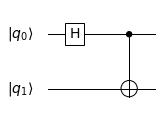

In [15]:
plot_quantum_circuit([(H,q0),(CNOT,q1,q0)])

Can also play with labeling, either turning them off, or selectively showing initializations:

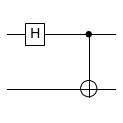

In [16]:
plot_quantum_circuit([(H,q0),(CNOT,q1,q0)],plot_labels=False)

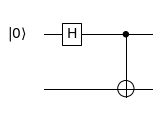

In [17]:
plot_quantum_circuit([(H,q0),(CNOT,q1,q0)],{q0:0,q1:None})

## Example 2: Teleportation Gate

Goal:

<img src="http://www.media.mit.edu/quanta/qasm2circ/test2.png" width="400" />

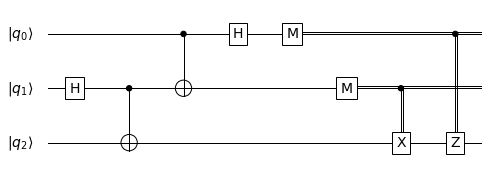

In [18]:
plot_quantum_circuit([(H,q1),(CNOT,q2,q1),(CNOT,q1,q0),(H,q0),
                      (M,q0),(M,q1),(CX,q2,q1),(CZ,q2,q0)],
                     labels=[q0,q1,q2])

## Example 3: Swap Gate

Goal:

<img src="http://www.media.mit.edu/quanta/qasm2circ/test3.png" width="200" />

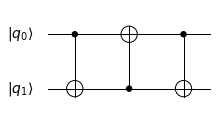

In [19]:
plot_quantum_circuit([(CNOT,q1,q0),(CNOT,q0,q1),(CNOT,q1,q0)],labels=[q0,q1])

## Example 4: QFT on 3 Qubits
Goal:

<img src="http://www.media.mit.edu/quanta/qasm2circ/test4.png" width="300"/>

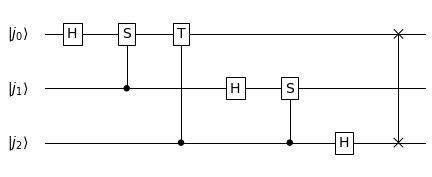

In [20]:
plot_quantum_circuit([(H,'j_0'),(S,'j_0','j_1'),(T,'j_0','j_2'),(H,'j_1'),
                     (S,'j_1','j_2'),(H,'j_2'),(SWAP,'j_0','j_2')])

## Example 6
Goal:

<img src="http://www.media.mit.edu/quanta/qasm2circ/test6.png" width="200" />

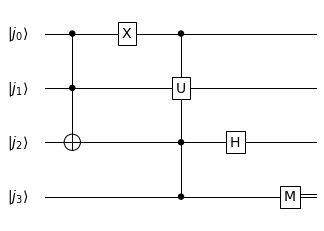

In [21]:
plot_quantum_circuit([(TOFFOLI,'j_2','j_0','j_1'),(X,'j_0'),('U','j_1','j_0','j_2','j_3'),
                     (H,'j_2'),(M,'j_3')],
                     labels=['j_0','j_1','j_2','j_3'])

## Example 7
Goal:

<img src="http://www.media.mit.edu/quanta/qasm2circ/test7.png" width="400" />

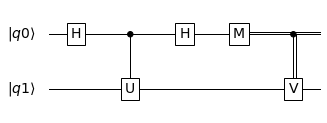

In [22]:
plot_quantum_circuit([(H,'q0'),('U','q1','q0'),(H,'q0'),(M,'q0'),('V','q1','q0')])

## Example 8
Goal:

<img src="http://www.media.mit.edu/quanta/qasm2circ/test8.png" width="400" />

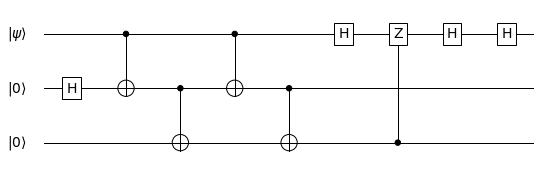

In [23]:
plot_quantum_circuit([(H,'b'),(CNOT,'b','a'),(CNOT,'c','b'),(CNOT,'b','a'),
                     (CNOT,'c','b'),(H,'a'),(Z,'a','c'),(H,'a'),(H,'a')],
                     labels='abc',inits=dict(a='\psi',b='0',c='0'))

## Example 9
Goal:

<img src="http://www.media.mit.edu/quanta/qasm2circ/test9.png" width="300" />


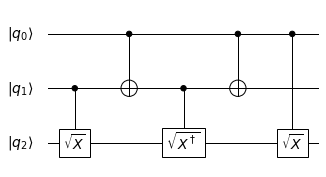

In [24]:
rt = r'$\sqrt{X}$'
rtd = r'$\sqrt{X^\dagger}$'
plot_quantum_circuit([(rt,q2,q1),(CNOT,q1,q0),(rtd,q2,q1),(CNOT,q1,q0),(rt,q2,q0)],
    labels=[q0,q1,q2]
)

## Example 13
Goal:

<img src="http://www.media.mit.edu/quanta/qasm2circ/test13.png" width="300" />
Can't do multitarget gates yet.

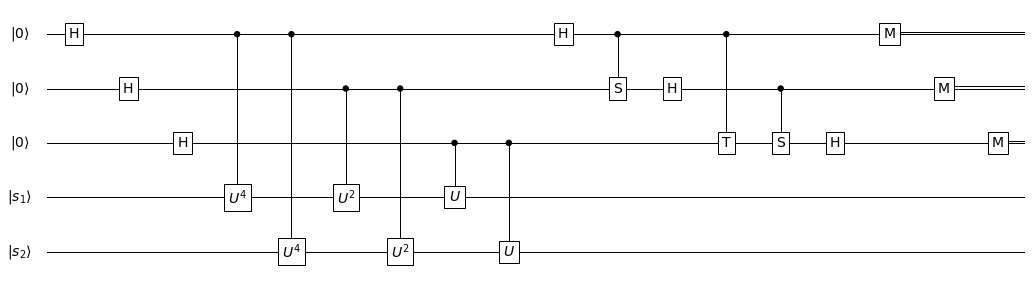

In [25]:
j0,j1,j2,s1,s2 = 'j_0','j_1','j_2','s_1','s_2'
plot_quantum_circuit([(H,j0),(H,j1),(H,j2),(r'$U^4$',s1,j0),(r'$U^4$',s2,j0),
                      (r'$U^2$',s1,j1),(r'$U^2$',s2,j1),(r'$U$',s1,j2),(r'$U$',s2,j2),
                      (H,j0),(S,j1,j0),(H,j1),(T,j2,j0),(S,j2,j1),(H,j2),
                      (M,j0),(M,j1),(M,j2)],
    labels=(j0,j1,j2,s1,s2),inits={j0:0,j1:0,j2:0})

## Experimenting with plotting scheduled gates:
The above scheme, like what's in Scipy, prints one gate per time step. What if we define a *schedule* as a sequence of steps, each of which can have multple gates. At some point we could write a *scheduler* that would take a sequence of gates and compress it as much as possible. In the meantime, we could manually schedule gates.

We don't have to rewrite very much of the code to do this. We just define a custom enumerator *enumerate_gates* that can work with either a schedule or a gate list, and everything works as before.

In [26]:
def plot_quantum_schedule(schedule,inits={},labels=[],plot_labels=True,**kwargs):
    """Use Matplotlib to plot a quantum circuit.
    schedule  List of time steps, each containing a sequence of gates during that step.
              Each gate is a tuple containing (name,target,control1,control2...). 
              Targets and controls initially defined in terms of labels. 
    inits     Initialization list of gates, optional
    
    kwargs    Can override plot_parameters
    """
    plot_params = dict(scale = 1.0,fontsize = 14.0, linewidth = 1.0, 
                         control_radius = 0.05, not_radius = 0.15, 
                         swap_delta = 0.08, label_buffer = 0.0)
    plot_params.update(kwargs)
    scale = plot_params['scale']
    
    # Create labels from gates. This will become slow if there are a lot 
    #  of gates, in which case move to an ordered dictionary
    if not labels:
        labels = []
        for i,gate in enumerate_gates(schedule,schedule=True):
            for label in gate[1:]:
                if label not in labels:
                    labels.append(label)
    
    nq = len(labels)
    nt = len(schedule)
    wire_grid = np.arange(0.0, nq*scale, scale, dtype=float)
    gate_grid = np.arange(0.0, nt*scale, scale, dtype=float)
    
    fig,ax = setup_figure(nq,nt,gate_grid,wire_grid,plot_params)

    measured = measured_wires(schedule,labels,schedule=True)
    draw_wires(ax,nq,gate_grid,wire_grid,plot_params,measured)
    
    if plot_labels: 
        draw_labels(ax,labels,inits,gate_grid,wire_grid,plot_params)

    draw_gates(ax,schedule,labels,gate_grid,wire_grid,plot_params,measured,schedule=True)
    return ax



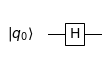

In [27]:
plot_quantum_schedule([[(H,q0)]])

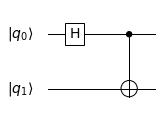

In [28]:
plot_quantum_schedule([[(H,q0)],[(CNOT,q1,q0)]])

Now plot something that we can't do with the original code:

## Example 13
Goal:

<img src="http://www.media.mit.edu/quanta/qasm2circ/test13.png" width="300" />


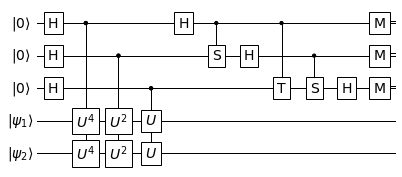

In [29]:
j0,j1,j2,s1,s2 = 'j_0','j_1','j_2','\psi_1','\psi_2' # labeler puts in the r$$ stuff
plot_quantum_schedule([[(H,j0),(H,j1),(H,j2)],[(r'$U^4$',s1,j0),(r'$U^4$',s2,j0)],
                      [(r'$U^2$',s1,j1),(r'$U^2$',s2,j1)],[(r'$U$',s1,j2),(r'$U$',s2,j2)],
                      [(H,j0)],[(S,j1,j0)],[(H,j1)],[(T,j2,j0)],[(S,j2,j1)],[(H,j2)],
                      [(M,j0),(M,j1),(M,j2)]],
                      labels=(j0,j1,j2,s1,s2),inits={j0:0,j1:0,j2:0},scale=0.6)

In [30]:
def make_schedule(gates):
    schedule = [[]]
    current_tic = schedule[-1]
    qubits_in_current_tic = set()
    for gate in gates:
        qubits = set(gate[1:])
        if qubits_in_current_tic.intersection(qubits): 
            # Qubits already in tic, create new tic
            current_tic = [gate]
            qubits_in_current_tic = qubits
            schedule.append(current_tic)
        else:
            # Add to current tic
            current_tic.append(gate)
            qubits_in_current_tic = qubits_in_current_tic.union(qubits)
    return schedule

In [31]:
gates = [(H,j0),(H,j1),(H,j2),(r'$U^4$',s1,j0),(r'$U^4$',s2,j0),
         (r'$U^2$',s1,j1),(r'$U^2$',s2,j1),(r'$U$',s1,j2),(r'$U$',s2,j2),
         (H,j0),(S,j1,j0),(H,j1),(T,j2,j0),(S,j2,j1),(H,j2),
         (M,j0),(M,j1),(M,j2)]

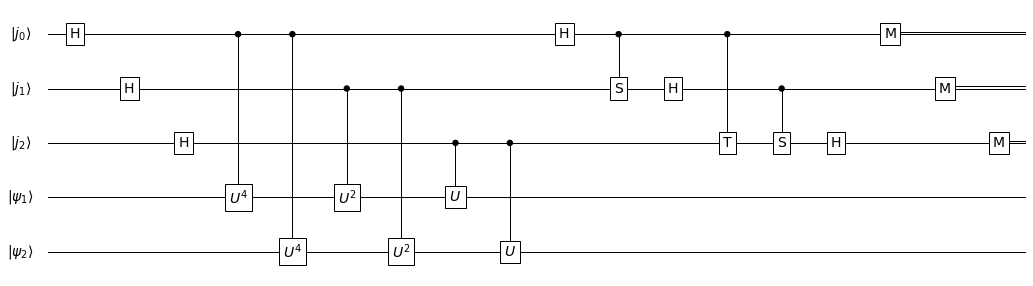

In [32]:
plot_quantum_circuit(gates)

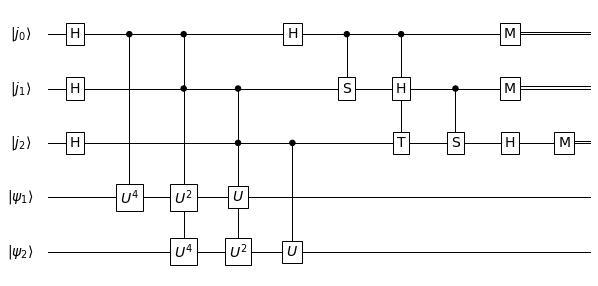

In [33]:
plot_quantum_schedule(make_schedule(gates))

Not bad! Several things could be improved. The H|j0> in the QFT could be moved up a step. Would be nice to combine the C-U's a little more intelligently.

## Multiqubit Boxes
Experimenting with rectangle code

Todo:
* Pass plot_params into rectangle.
* Test multiqubit_box
* get box to cover wires.
* In order to wire these into circuits a little more intelligently, need a good way to put multitarget gates into circuits.

In [34]:
def multiqubit_box(ax,istep,minq,maxq,labels,gate_grid,wire_grid,plot_params,label=''):
    dx = 0.25
    dy = 0.25
    minwire = get_flipped_index(minq,labels)
    maxwire = get_flipped_index(maxq,labels)
    
    rectangle(ax,gate_grid[istep]-dx,gate_grid[istep]+dx,
              wire_grid[minwire]-dy,wire_grid[maxwire]+dy,label=label)
    return


def rectangle(ax,x1,x2,y1,y2,label=''):
    Rectangle = matplotlib.patches.Rectangle
    x = min(x1,x2)
    y = min(y1,y2)
    w = abs(x2-x1)
    h = abs(y2-y1)
    xm = x+w/2.
    ym = y+h/2.
    print (x,y,w,h,xm,ym)
    rect = Rectangle((x,y),w,h,ec='k',fc='w',fill=True,lw=1,label=label)
    ax.add_patch(rect)
    if label:
        ax.text(xm,ym,label,ha='center',color='k')
    return
    


-0.25 -0.25 0.5 1.5 0.0 0.5


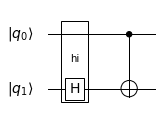

In [35]:
plot_params = dict(scale = 1.0,fontsize = 14.0, linewidth = 1.0, 
                   control_radius = 0.05, not_radius = 0.15, 
                   swap_delta = 0.08, label_buffer = 0.0)

ax = plot_quantum_circuit([(H,q1),(CNOT,q1,q0)],labels=[q0,q1])
#r = matplotlib.patches.Rectangle((-0.25,-0.25),0.5,1.5,ec='k',fc='w',fill=True,lw=1.0)
#ax.add_patch(r)
#ax.text(0,0.5,"Hi",ha="center")

#color='k',ha='center',va='center',bbox=bbox,size=fontsize
rectangle(ax,-0.25,0.25,-0.25,1.25,'hi')
#   ax.text(x,y,textstr,color='k',ha='center',va='center',bbox=bbox,size=fontsize)
 